# Comparing AMP VS DEL

In [2]:
from pycirclize import Circos
from pycirclize.parser import Gff, Genbank
from pycirclize.utils import load_prokaryote_example_file
from matplotlib.patches import Patch


In [3]:
import pandas as pd
df = pd.read_csv("final_gene.csv")
df.drop(columns=df.columns[0], axis=1, inplace=True)
# 4th col is the comments
# df.drop(columns=df.columns[4], axis=1, inplace=True)
df.drop(columns=df.columns[5], axis=1, inplace=True)
df.drop(columns=df.columns[6], axis=1, inplace=True)
df

,Chr,Start,End,q values,Description,Chromosome_num,Strand
0,chr1,39109153,41523062,1.280000e-21,1p34.2(MYCL1),1,+
1,chr1,148646436,149486905,5.190000e-18,1q21.2(MCL1),1,+
2,chr1,232526850,233617929,8.670000e-07,1q42.3(IRF2BP2),1,+
3,chr1,154088696,154329131,3.880000e-09,---,1,+
4,chr1,36338557,36480225,2.120000e-11,1p34.3,1,+
...,...,...,...,...,...,...,...
108,chr19,1,306931,3.030000e-56,19p13.3,19,-
109,chr19,45712960,55025072,4.274900e-02,---,19,-
110,chr21,41501909,46944323,4.164300e-02,---,21,-
111,chr21,1,23298229,1.032700e-04,---,21,-


In [4]:
df['dist'] = df['End'] - df['Start']

# Determine the maximum distance for each chromosome and add it as a new column
df['max_distance'] = df.groupby('Chr')['dist'].transform('max')

# Add the minimum start value for each chromosome to the DataFrame
df['min_start'] = df.groupby('Chr')['Start'].transform('min')

# Add the maximum end value for each chromosome to the DataFrame
df['max_end'] = df.groupby('Chr')['End'].transform('max')

df['n_start'] = ((df['Start'] - df['min_start']) * df['max_distance']) / (df['max_end'] - df['min_start'])
df['n_end'] = ((df['End'] - df['min_start']) * df['max_distance']) / (df['max_end'] - df['min_start'])

df_copy = df.copy()
df

,Chr,Start,End,q values,Description,Chromosome_num,Strand,dist,max_distance,min_start,max_end,n_start,n_end
0,chr1,39109153,41523062,1.280000e-21,1p34.2(MYCL1),1,+,2413909,62675788,1,247249719,9.913851e+06,1.052576e+07
1,chr1,148646436,149486905,5.190000e-18,1q21.2(MCL1),1,+,840469,62675788,1,247249719,3.768066e+07,3.789371e+07
2,chr1,232526850,233617929,8.670000e-07,1q42.3(IRF2BP2),1,+,1091079,62675788,1,247249719,5.894366e+07,5.922024e+07
3,chr1,154088696,154329131,3.880000e-09,---,1,+,240435,62675788,1,247249719,3.906023e+07,3.912118e+07
4,chr1,36338557,36480225,2.120000e-11,1p34.3,1,+,141668,62675788,1,247249719,9.211528e+06,9.247439e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,chr19,1,306931,3.030000e-56,19p13.3,19,-,306930,9312112,1,63811651,0.000000e+00,4.479067e+04
109,chr19,45712960,55025072,4.274900e-02,---,19,-,9312112,9312112,1,63811651,6.670948e+06,8.029876e+06
110,chr21,41501909,46944323,4.164300e-02,---,21,-,5442414,23298228,1,46944323,2.059719e+07,2.329823e+07
111,chr21,1,23298229,1.032700e-04,---,21,-,23298228,23298228,1,46944323,0.000000e+00,1.156279e+07


In [5]:
temp = df.groupby("Chr")[["max_distance"]].first().reset_index()
temp

,Chr,max_distance
0,chr1,62675788
1,chr10,37313851
2,chr11,32234329
3,chr12,58092402
4,chr13,22945559
5,chr14,20721261
6,chr15,30715294
7,chr16,9508767
8,chr17,5292353
9,chr18,6499643


In [7]:
def extract_numeric_part(chromosome):
    return int(chromosome[3:])

temp['Chromosome_num'] = temp['Chr'].apply(extract_numeric_part)

temp = temp.sort_values(by='Chromosome_num')
temp

com_df = pd.DataFrame({
    "seqname": temp["Chr"],
    "source": "RefSeq",
    "feature": "region",
    "start": 1,
    "end": temp["max_distance"],
    "score": ".",
    "strand": "+",
    "frame": ".",
    "attribute": "ID=" + temp["Chr"] + ";comments=range_of_" + temp["Chr"] 
})

# Creating the GFF formatted content
gff_content = com_df.to_csv(sep='\t', index=False, header=False)
gff_file_path = './compare_dist.txt'
with open(gff_file_path, 'w') as file:
    file.write(gff_content)


## after excuting the above code, we can copy the indvidual lines and paste it over to compareTest.gff or compare_with_description_GFF
Remeber it's before the start of each chr

{'chr1': 62675788, 'chr2': 26477917, 'chr3': 9517824, 'chr4': 27922381, 'chr5': 30205690, 'chr6': 34670835, 'chr7': 11853446, 'chr8': 2503918, 'chr9': 10059948, 'chr10': 37313851, 'chr11': 32234329, 'chr12': 58092402, 'chr13': 22945559, 'chr14': 20721261, 'chr15': 30715294, 'chr16': 9508767, 'chr17': 5292353, 'chr18': 6499643, 'chr19': 9312112, 'chr20': 1024003, 'chr21': 23298228, 'chr22': 316998}
22
{'chr1': [SeqFeature(SimpleLocation(ExactPosition(0), ExactPosition(62675788), strand=1), type='region', id='chr1', qualifiers=...), SeqFeature(SimpleLocation(ExactPosition(37680658), ExactPosition(37893711), strand=1), type='amp', id='chr1', qualifiers=...), SeqFeature(SimpleLocation(ExactPosition(58943659), ExactPosition(59220240), strand=1), type='amp', id='chr1', qualifiers=...), SeqFeature(SimpleLocation(ExactPosition(39060227), ExactPosition(39121176), strand=1), type='amp', id='chr1', qualifiers=...), SeqFeature(SimpleLocation(ExactPosition(9211526), ExactPosition(9247439), strand=1

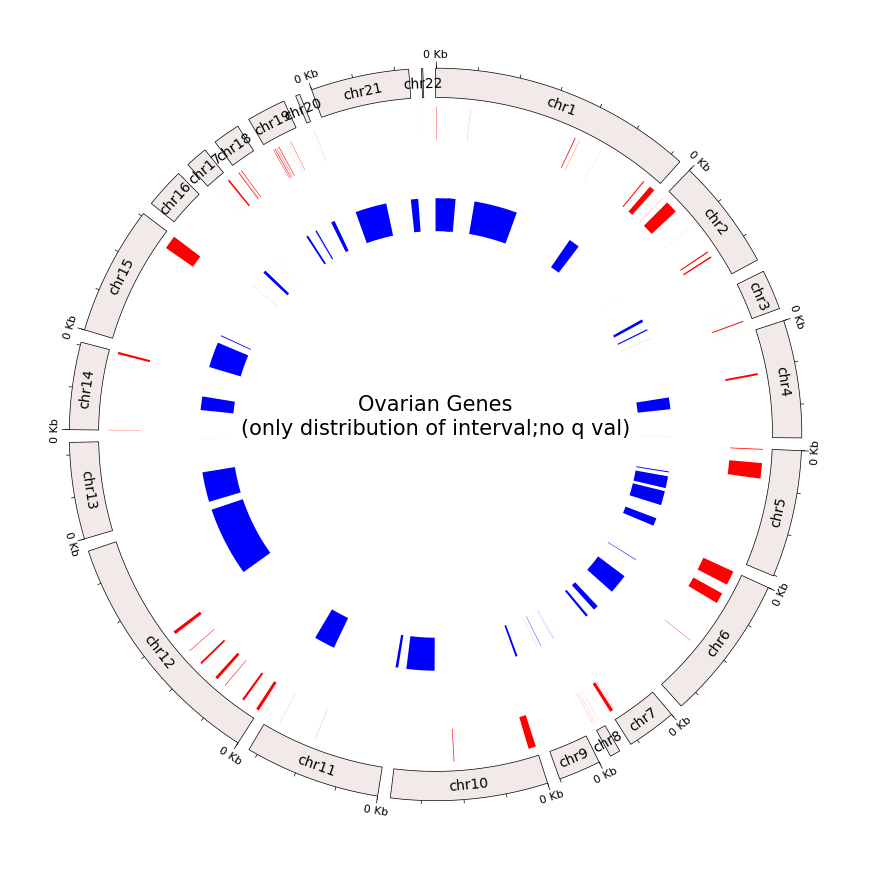

In [14]:

# parser = Gff("./compareTest.gff")

parser = Gff("./compare_with_description.gff")

# Get contig genome seqid & size, features dict
seqid2size = parser.get_seqid2size()
print(seqid2size)
print(len(seqid2size))
seqid2features = parser.get_seqid2features(feature_type=None)
print(seqid2features)
print(len(seqid2features))


circos = Circos(seqid2size, space=2)
circos.text(f"Ovarian Genes\n(only distribution of interval;no q val)", r=5, size=15)

a = 0
d = 0
amp_pos_list, amp_labels = [], []
del_pos_list, del_labels = [], []
for sector in circos.sectors:
    for feature in seqid2features[sector.name]:
        st = feature.location.start
        ed = feature.location.end
        label = feature.qualifiers["comments"][0]
        pos = (int(st) + int(ed)) / 2
        if feature.type == "amp":
            a += 1
            amp_pos_list.append(pos)
            amp_labels.append(label)
        elif feature.type == "del":
            d += 1
            del_pos_list.append(pos)
            del_labels.append(label)
print(a,d)

for sector in circos.sectors:
    # Plot outer track
    outer_track = sector.add_track((92, 100))
    outer_track.axis(fc="#f2e9e9")
    outer_track.text(sector.name)
    major_interval = 100000000
    minor_interval = int(major_interval / 10)
    if sector.size > minor_interval:
        outer_track.xticks_by_interval(major_interval, label_formatter=lambda v: f"{v / 1000000:.0f} Kb")
        outer_track.xticks_by_interval(minor_interval, tick_length=1, show_label=False)

    # Plot forward/reverse CDS, rRNA, tRNA tracks
    amp_track = sector.add_track((80, 90), r_pad_ratio=0.1)
    # amp_track.axis(fc="#ebf2f1")
    del_track = sector.add_track((55, 65), r_pad_ratio=0.1)
    for feature in seqid2features[sector.name]:
        if feature.type == "amp":
            amp_track.genomic_features([feature], fc="red")
            
        elif feature.type == "del":
            del_track.genomic_features([feature], fc="blue")


fig = circos.plotfig()